In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns

### Code 7.1

In [2]:
sppnames = ['afarensis', 'africanus', 'habilis', 'boisei', 'rudolfensis', 'ergaster', 'sapiens']
brainvolcc = [438, 452, 612, 521, 752, 871, 1350]
masskg = [37.0, 35.5, 34.5, 41.5, 55.5, 61.0, 53.5]

df = pd.DataFrame({'species': sppnames, 'brain': brainvolcc, 'mass': masskg})
df

,species,brain,mass
0,afarensis,438,37.0
1,africanus,452,35.5
2,habilis,612,34.5
3,boisei,521,41.5
4,rudolfensis,752,55.5
5,ergaster,871,61.0
6,sapiens,1350,53.5


In [3]:
df[['brain', 'mass']].corr()

,brain,mass
brain,1.000000,0.700113
mass,0.700113,1.000000


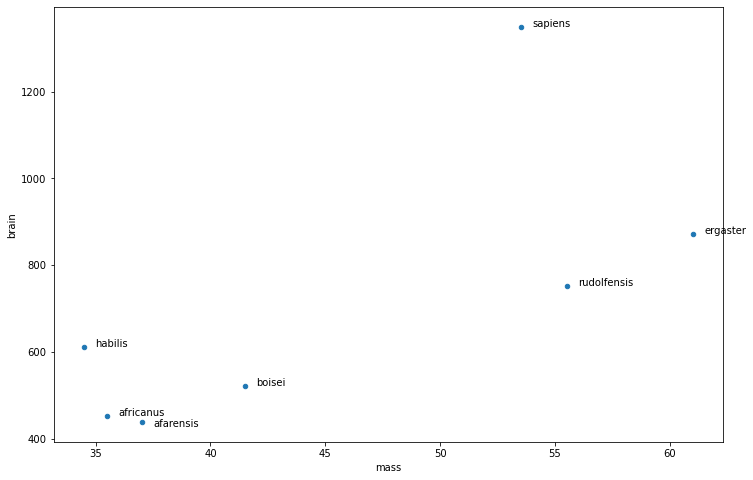

In [4]:
fig, ax = plt.subplots(figsize=(12, 8))
df.plot(x='mass', y='brain', kind='scatter', ax=ax)

for k, row in df.iterrows():
    y_offset = 0.5
    x_offset = 0.5
    
    if row['species'] == 'afarensis':
        y_offset = -10.0
    
    ax.annotate(row['species'], xy=(row['mass'] + x_offset, row['brain'] + y_offset))

### Code 7.2

In [5]:
df['mass_std'] = (df['mass'] - df['mass'].mean()) / df['mass'].std()
df['brain_std'] = df['brain'] / df['brain'].max()

In [6]:
df[['mass_std', 'brain_std']].describe([0.055, 0.945])

,mass_std,brain_std
count,7.000000e+00,7.000000
mean,3.172066e-17,0.528677
std,1.000000e+00,0.238702
min,-1.008722e+00,0.324444
5.5%,-9.784600e-01,0.327867
50%,-3.668079e-01,0.453333
94.5%,1.254941e+00,0.882911
max,1.421380e+00,1.000000


## Model 1

$$
\begin{array}
~b_i     & \sim \text{Normal}(\mu_i, \sigma) \\
\mu_i   & = \alpha + \beta \cdot m_i \\
\alpha  & \sim \text{Normal}(0.5, 1) \\
\beta   & \sim \text{Normal}(0, 10) \\
\sigma  & \sim \text{Log-Normal}(0, 1) \\
\end{array}
$$

### Code 7.3

In [7]:
with pm.Model() as m_7_1:
    alpha = pm.Normal('alpha', mu=0.5, sigma=1)
    beta = pm.Normal('beta', mu=0, sigma=10)
    sigma = pm.Lognormal('sigma', mu=0, sigma=1)
    
    mu = pm.Deterministic('mu', alpha + beta * df['mass_std'])
    b = pm.Normal('b', mu=mu, sigma=sigma, observed=df['brain_std'])
    
    trace_7_1 = pm.sample(2000, tune=2000)

az.summary(trace_7_1, var_names=['alpha', 'beta', 'sigma'], hdi_prob=0.89)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 9 seconds.
/home/somnath/install/anaconda3/envs/stat-rethink-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,0.528,0.107,0.363,0.692,0.002,0.001,4330.0,4089.0,4713.0,3365.0,1.0
beta,0.167,0.119,-0.011,0.346,0.002,0.002,4573.0,2560.0,5100.0,3168.0,1.0
sigma,0.266,0.116,0.118,0.403,0.002,0.002,2231.0,2208.0,2481.0,3032.0,1.0


In [8]:
df_7_1 = pm.trace_to_dataframe(trace_7_1)
df_7_1.head()

,alpha,beta,sigma,mu__0,mu__1,mu__2,mu__3,mu__4,mu__5,mu__6
0,0.620954,0.316756,0.224057,0.374054,0.330483,0.301436,0.504766,0.911425,1.071185,0.853331
1,0.648030,0.386827,0.222685,0.346511,0.293302,0.257829,0.506139,1.002757,1.197858,0.931812
2,0.393742,0.273869,0.413267,0.180271,0.142599,0.117485,0.293285,0.644885,0.783014,0.594657
3,0.447287,0.088023,0.151953,0.378676,0.366568,0.358496,0.415000,0.528007,0.572402,0.511863
4,0.538259,0.110326,0.168785,0.452264,0.437089,0.426972,0.497791,0.639430,0.695074,0.619196


In [9]:
with m_7_1:
    ppc = pm.sample_posterior_predictive(trace_7_1, var_names=['b'])

In [10]:
def calculate_r2_score(posterior_data: np.array, actual_data: np.array = df['brain_std'].values):
    SPECIES = ['afarensis', 'africanus', 'habilis', 'boisei', 'rudolfensis', 'ergaster', 'sapiens']
    
    df_post = pd.DataFrame(data=posterior_data, 
                            index=range(posterior_data.shape[0]), 
                            columns=SPECIES)

    NUM_SAMPLES = df_post.shape[0]
    actual_data_arr = np.tile(actual_data, (NUM_SAMPLES, 1))
    df_actual = pd.DataFrame(data=actual_data_arr, 
                              index=range(NUM_SAMPLES), 
                              columns=SPECIES)
    
    df_resid = df_post - df_actual
    
    mean_post_resid = df_resid.mean(axis=0)
    resid_var = mean_post_resid.var()
    return (1 - resid_var / actual_data.var())

In [11]:
ppc['b'][0]
data = ppc['b']
calculate_r2_score(posterior_data=data)

0.39985526445220165